# Chinese characters generator 

In [1]:
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime, timedelta

%matplotlib inline

In [2]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Reshape, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D, Conv2DTranspose, Conv2D

from keras.optimizers import SGD, RMSprop

Using TensorFlow backend.


## Data

In [43]:
filename = "./data/vector300_2hier64x64_19_01_18_00_01_35.txt"

X_vec = []
Y_img = []

img_size = 64
wcount = 0
for line in open(filename):
    vec, img = line[:-1].split(",")
    
    vec = np.array([float(n) for n in vec.split(" ")])
    img = np.array([float(n) / 255 - 127 for n in img.split(" ")])
        
    img = np.reshape(img, (img_size, img_size, 1))
    
    X_vec.append(vec)
    Y_img.append(img)
    
    wcount += 1
    if (wcount % 10000 == 0):
        print("{} words processed".format(wcount))
#     if wcount > 100000:
#         break
        
print("{} words processed".format(wcount))

Y_img = np.array(Y_img)
X_vec = np.array(X_vec)

10000 words processed
20000 words processed
30000 words processed
40000 words processed
50000 words processed
60000 words processed
70000 words processed
80000 words processed
90000 words processed
100000 words processed
110000 words processed
120000 words processed
130000 words processed
140000 words processed
150000 words processed
160000 words processed
170000 words processed
180000 words processed
190000 words processed
198853 words processed


In [44]:
Y_img.shape

(198853, 64, 64, 1)

## Visualisation

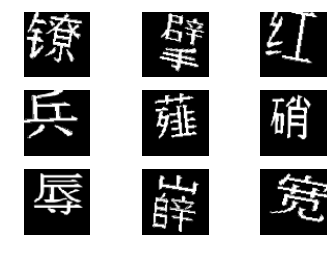

In [45]:
images = Y_img[np.random.randint(0, Y_img.shape[0], 
                                 size=9)]

for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(images[i].reshape(img_size, img_size), cmap=plt.get_cmap('gray'))
    plt.axis('off')
plt.show()

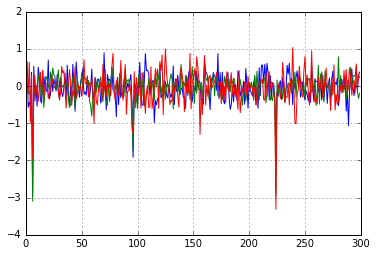

In [46]:
vectors = X_vec[np.random.randint(0, X_vec.shape[0], 
                                  size=3)]

for i in range(3):
    plt.plot(vectors[i])
    
plt.grid()
plt.show()

# GAN
## Generator

In [47]:
gen_dropout = 0.3
gen_input_dim = 8
gen_depth = 512
gen_noise_dim = 300

In [48]:
gennet = Sequential()

# Input 
# fully-connected layer
gennet.add(Dense(gen_input_dim * gen_input_dim * gen_depth, 
                 input_dim=gen_noise_dim))
gennet.add(BatchNormalization(momentum=0.9))
gennet.add(Activation('relu'))
gennet.add(Reshape((gen_input_dim, gen_input_dim, gen_depth)))
gennet.add(Dropout(gen_dropout))

# Deconvolution layers
gennet.add(UpSampling2D())
gennet.add(Conv2DTranspose(int(gen_depth / 2), 5, padding='same'))
gennet.add(BatchNormalization(momentum=0.9))
gennet.add(Activation('relu'))

gennet.add(Conv2DTranspose(int(gen_depth / 2), 5, padding='same'))
gennet.add(BatchNormalization(momentum=0.9))
gennet.add(Activation('relu'))


gennet.add(UpSampling2D())
gennet.add(Conv2DTranspose(int(gen_depth / 4), 5, padding='same'))
gennet.add(BatchNormalization(momentum=0.9))
gennet.add(Activation('relu'))

gennet.add(Conv2DTranspose(int(gen_depth / 4), 5, padding='same'))
gennet.add(BatchNormalization(momentum=0.9))
gennet.add(Activation('relu'))


gennet.add(UpSampling2D())
gennet.add(Conv2DTranspose(int(gen_depth / 8), 5, padding='same'))
gennet.add(BatchNormalization(momentum=0.9))
gennet.add(Activation('relu'))

gennet.add(Conv2DTranspose(int(gen_depth / 8), 5, padding='same'))
gennet.add(BatchNormalization(momentum=0.9))
gennet.add(Activation('relu'))


gennet.add(Conv2DTranspose(int(gen_depth / 16), 5, padding='same'))
gennet.add(BatchNormalization(momentum=0.9))
gennet.add(Activation('relu'))

# Output
gennet.add(Conv2DTranspose(1, 5, padding='same'))
gennet.add(Activation('tanh'))

gennet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 32768)             9863168   
_________________________________________________________________
batch_normalization_25 (Batc (None, 32768)             131072    
_________________________________________________________________
activation_53 (Activation)   (None, 32768)             0         
_________________________________________________________________
reshape_5 (Reshape)          (None, 8, 8, 512)         0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 8, 8, 512)         0         
_________________________________________________________________
up_sampling2d_13 (UpSampling (None, 16, 16, 512)       0         
_________________________________________________________________
conv2d_transpose_25 (Conv2DT (None, 16, 16, 256)       3277056   
__________

## Discriminator

In [49]:
disc_depth = 64
disc_dropout = 0.3

discnet = Sequential()

# Input
discnet.add(Conv2D(disc_depth, 5, strides=2, input_shape=(64, 64, 1), 
                   padding='same'))
discnet.add(Activation('relu'))
discnet.add(Dropout(disc_dropout))

discnet.add(Conv2D(disc_depth*2, 5, strides=2, padding='same'))
discnet.add(Activation('relu'))
discnet.add(Dropout(disc_dropout))

discnet.add(Conv2D(disc_depth*4, 5, strides=2, padding='same'))
discnet.add(Activation('relu'))
discnet.add(Dropout(disc_dropout))

discnet.add(Conv2D(disc_depth*8, 5, strides=2, padding='same'))
discnet.add(Activation('relu'))
discnet.add(Dropout(disc_dropout))

discnet.add(Conv2D(disc_depth*16, 5, strides=2, padding='same'))
discnet.add(Activation('relu'))
discnet.add(Dropout(disc_dropout))

# Out: scalar estimation of probability
discnet.add(Flatten())
discnet.add(Dense(1))
discnet.add(Activation('sigmoid'))

discnet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 32, 32, 64)        1664      
_________________________________________________________________
activation_62 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 16, 16, 128)       204928    
_________________________________________________________________
activation_63 (Activation)   (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 8, 8, 256)         819456    
__________

## Discriminator model

In [50]:
discmodel = Sequential()
discmodel.add(discnet)
discmodel.compile(loss='binary_crossentropy', 
                  optimizer=RMSprop(lr=0.0002, clipvalue=1.0, decay=6e-8),
                  metrics=['accuracy'])

## Adversarial model

In [51]:
advmodel = Sequential()
advmodel.add(gennet)
advmodel.add(discnet)
advmodel.compile(loss='binary_crossentropy', 
                 optimizer=RMSprop(lr=0.0001, clipvalue=1.0, decay=3e-8),
                 metrics=['accuracy'])

## Training

In [52]:
disc_losses = {"loss": [], "acc": []}
adv_losses = {"loss": [], "acc": []}

In [ ]:
batch_size = 128
train_iters = 2000

log_i = 0

start_time = time.time()

for i in range(train_iters):
    # Get random real images
    images_true = Y_img[np.random.randint(0, 
                                          Y_img.shape[0], 
                                          size=batch_size)]
    # Generate images from noise
    noise = np.random.uniform(-1.0, 1.0, 
                              size=[batch_size, gen_noise_dim])
    images_fake = gennet.predict(noise)
    # Compose training data for discriminator
    x = np.concatenate((images_true, images_fake))
    y = np.concatenate((np.ones((batch_size, 1)), 
                        np.zeros((batch_size, 1))))
    # Train discriminator on composed data
    dics_loss = discmodel.train_on_batch(x, y)
    disc_losses["loss"].append(dics_loss[0])
    disc_losses["acc"].append(dics_loss[1])
    
    # Compose trainig data for adversarial net
    noise = np.random.uniform(-1.0, 1.0, 
                              size=[batch_size, gen_noise_dim])
    y = np.ones([batch_size, 1])
    # Train adversarial net on composed data
    adv_loss = advmodel.train_on_batch(noise, y)
    adv_losses["loss"].append(adv_loss[0])
    adv_losses["acc"].append(adv_loss[1])
    
    # Print results
    if i % 200 == 0:
        curr_time = time.time()
        time_est = (curr_time - start_time) * (train_iters - i + 1) / (i + 1)
        time_est_str = str(timedelta(seconds=time_est)).split('.')[0]
        print("{:4d}th batch of {:4d}|".format(i, train_iters) + \
              "Disc loss {:.3f} |Disc acc {:.3f} |Adv loss {:.3f} |Adv acc {:.3}|".format(dics_loss[0], 
                                                                                          dics_loss[1], 
                                                                                          adv_loss[0], 
                                                                                          adv_loss[1]) +\
              "Time est {}".format(time_est_str))

   0th batch of 2000|Disc loss 0.949 |Disc acc 0.535 |Adv loss 0.109 |Adv acc 1.0|Time est 2:05:30
 200th batch of 2000|Disc loss 0.837 |Disc acc 0.500 |Adv loss 0.446 |Adv acc 1.0|Time est 0:23:46


## Discriminator losses

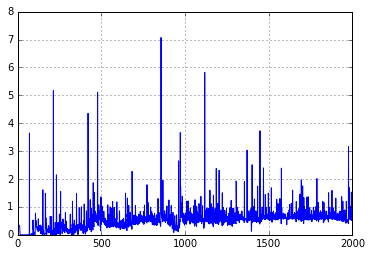

In [36]:
plt.plot(disc_losses["loss"])
plt.grid()

## Adversarial net losses

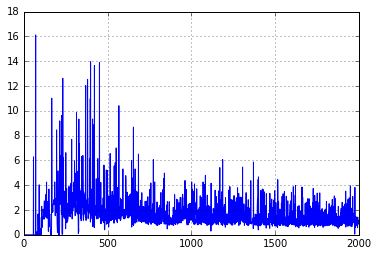

In [37]:
plt.plot(adv_losses["loss"])
plt.grid()

## An attempt to generate images

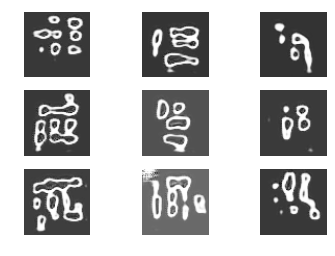

In [38]:
noise = np.random.uniform(-1.0, 1.0, size=[10, gen_noise_dim])
fake_images = gennet.predict(noise)

    
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(fake_images[i].reshape(64, 64), cmap=plt.get_cmap('gray'))
    plt.axis('off')
plt.show()